In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.cluster import KMeans
from keras import regularizers

In [ ]:
DATA_PATH = "/content/drive/MyDrive/AudioPatternRecognition/Final_Project/Data_kmeans.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
        :return kmeans_labels (ndarray): KMeans cluster labels
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists (Dictionary Data in the JSON file) to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    kmeans_labels = np.array(data["clusters"]) #Cluster labels assigned by KMeans (used to indicate which cluster each sample belongs to)

    return X, y, kmeans_labels

In [ ]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation, and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    :return kmeans_labels_train (ndarray): KMeans cluster labels for the training set
    :return kmeans_labels_validation (ndarray): KMeans cluster labels for the validation set
    :return kmeans_labels_test (ndarray): KMeans cluster labels for the test set
    """

    # load data
    X, y, kmeans_labels = load_data(DATA_PATH)

    # create train, validation and test split => (from sklearn.model_selection import train_test_split)
    # prepare_datasets(0.25, 0.2):
    # 0.25: This is the fraction of the dataset to be allocated for testing. For example, if the dataset contains 1,000 samples, 25% (250 samples) will be used as the test set.
    # 0.2: This is the fraction of the remaining data (after splitting off the test set) to be allocated for validation. For example, if 750 samples remain after the test split, 20% (150 samples) will be used as the validation set.

    # 1. First split (train and test sets)
    X_train, X_test, y_train, y_test, kmeans_labels_train, kmeans_labels_test = train_test_split(
        X, y, kmeans_labels, test_size=test_size)  # X_test, y_test, kmeans_labels_test are the test features, targets, and KMeans cluster labels, respectively.

    # 2. Second split (train and validation sets):
    X_train, X_validation, y_train, y_validation, kmeans_labels_train, kmeans_labels_validation = train_test_split(
        X_train, y_train, kmeans_labels_train, test_size=validation_size)  # X_validation, y_validation, kmeans_labels_validation are the features, targets, and KMeans cluster labels for the validation set.

    # add an axis (extra dimension) to input sets (CNN expects 3 dimensions) such as (130,13,1))
    X_train = X_train[..., np.newaxis] #... => means whatever the X_train is, + new axis => The result would be 4-dimention: (NumberOfSamples,130,13,1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, kmeans_labels_train, kmeans_labels_validation, kmeans_labels_test


In [ ]:
def build_model(input_shape):
    """Generates optimized RNN model with LSTM layers."""
    model = keras.Sequential()

    # First LSTM layer with regularization and return_sequences=True for stacking
    model.add(keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape))

    # Second LSTM layer
    model.add(keras.layers.LSTM(64, return_sequences=True))


    # Third LSTM layer with fewer units to reduce complexity
    model.add(keras.layers.LSTM(64))
    model.add(keras.layers.LayerNormalization())

    # Fully connected layer with Layer Normalization
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.1))

    # Output layer for classification
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1) => we insert new axis in the begining of the array.

    # perform prediction => a 2 dimantional array and have 10 different values as scores for our 10 different genres: [[0.1, 0.2, ...]] ==> we should extract the index with the max value.
    prediction = model.predict(X)   # X -> (1,130,13,1) => the forst dimention (1) is the number of samples we want to predict (usually usefull in batch prediction)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1) # argmax => extract the index with the max value => [4]

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model using a Confusion Matrix, Accuracy, Precision, and Recall.

    :param model: Trained CNN model
    :param X_test: Test dataset features
    :param y_test: True labels for the test dataset
    """

    # Get model predictions
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class labels

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report (includes Precision, Recall, F1-score, and Accuracy)
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    # Accuracy = (TP + TN) / (Total Samples)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels, digits=4))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1690, 128)           │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1690, 64)            │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 153,930 (601.29 KB)

 Trainable params: 153,930 (601.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 998s 5s/step - accuracy: 0.1523 - loss: 2.3046 - val_accuracy: 0.2790 - val_loss: 2.0315
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1036s 5s/step - accuracy: 0.2626 - loss: 2.0163 - val_accuracy: 0.3712 - val_loss: 1.8224
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1033s 5s/step - accuracy: 0.3246 - loss: 1.8883 - val_accuracy: 0.3805 - val_loss: 1.7710
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 974s 5s/step - accuracy: 0.3428 - loss: 1.8273 - val_accuracy: 0.3825 - val_loss: 1.7324
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 984s 5s/step - accuracy: 0.3465 - loss: 1.8053 - val_accuracy: 0.3919 - val_loss: 1.7006
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 980s 5s/step - accuracy: 0.3662 - loss: 1.7445 - val_accuracy: 0.3932 - val_loss: 1.6884
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 982s 5s/step - accuracy: 0.3701 - loss: 1.7374 - val_accuracy: 0.3999 - val_loss: 1.6900
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 963s 5s/step - accuracy: 0.3796 - loss: 1.7101 - val_ac

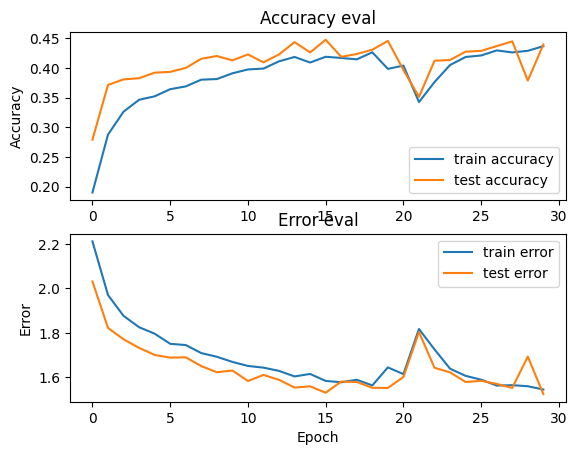

79/79 - 107s - 1s/step - accuracy: 0.4209 - loss: 1.5483

Test accuracy: 0.42090508341789246
True label: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step


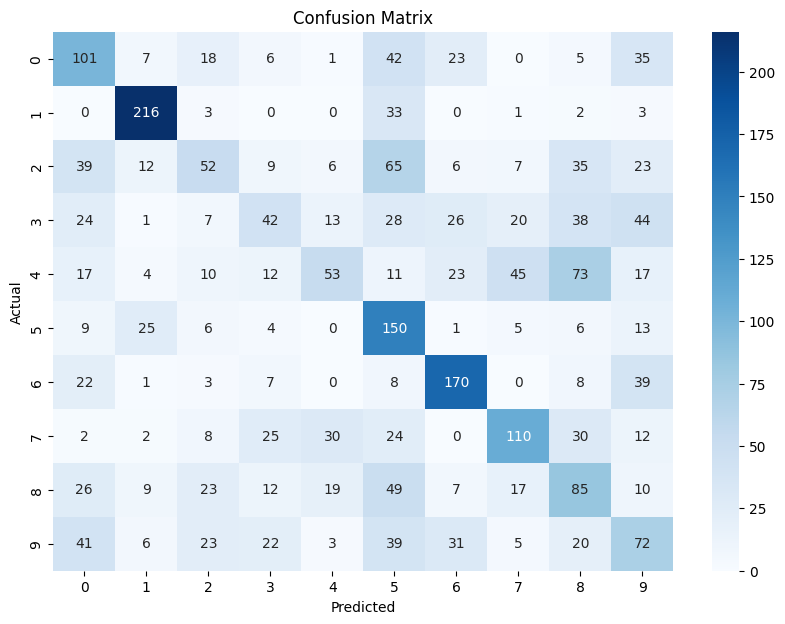

Classification Report:
              precision    recall  f1-score   support

           0     0.3594    0.4244    0.3892       238
           1     0.7633    0.8372    0.7985       258
           2     0.3399    0.2047    0.2555       254
           3     0.3022    0.1728    0.2199       243
           4     0.4240    0.2000    0.2718       265
           5     0.3341    0.6849    0.4491       219
           6     0.5923    0.6589    0.6239       258
           7     0.5238    0.4527    0.4857       243
           8     0.2815    0.3307    0.3041       257
           9     0.2687    0.2748    0.2717       262

    accuracy                         0.4209      2497
   macro avg     0.4189    0.4241    0.4069      2497
weighted avg     0.4207    0.4209    0.4068      2497

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
Target: 8, Predicted label: [8]


In [ ]:
if __name__ == "__main__":

    # Prepare datasets with kmeans labels
    #1. get train, validation, test splits => (Train the model with train dataset, use validation dataset for model optimization, test the model with test dataset which model hasnt seen befor)
    # 0.25: This is the fraction of the dataset to be allocated for testing. For example, if the dataset contains 1,000 samples, 25% (250 samples) will be used as the test set.
    # 0.2: This is the fraction of the remaining data (after splitting off the test set) to be allocated for validation. For example, if 750 samples remain after the test split, 20% (150 samples) will be used as the validation set.
    X_train, X_validation, X_test, y_train, y_validation, y_test, kmeans_labels_train, kmeans_labels_validation, kmeans_labels_test = prepare_datasets(0.25, 0.2)

    #2. create network ====> Changed! => 1. the 3rd dimention from input_shape is removed. => Also "build_model" should change
    input_shape = (X_train.shape[1], X_train.shape[2]) # First dimention=130= number of time steps (slices) at whitch we take the MFCCs, Second dimention=13 = number of MFCCs=number of MFCCs we extract
    model = build_model(input_shape)

    #3. compile model ====> Same Setting as CNN
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model ====> Same Setting as CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation ====> Same Setting as CNN
    plot_history(history)

    # evaluate model on test set ====> Same Setting as CNN
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]
    print(f"True label: {y_to_predict}")
    model.predict(X_to_predict[np.newaxis, ...])  # For prediction, we need to add an axis

    # Call the evaluation function
    evaluate_model(model, X_test, y_test)

    # predict sample
    predict(model, X_to_predict, y_to_predict)

In [ ]:
# Keras H5 format
model.save("model.h5")